This file is just my code, the report and presentations are separate.

Below I am loading in packages that will assist me with plotting, making maps, reading geojson files, using kmeans clustering etc.

In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import cv2
import matplotlib.pyplot as plt

First I want to open a data frame that includes information on Tokyo wards, their population, and their density.

In [31]:
df = pd.read_csv('Book1.csv')
df.head()

Ward  Population  Density
0   Chiyoda       59441     5100
1      Chuo      147620    14460
2    Minato      248071    12180
3  Shinjuku      339211    18620
4    Bunkyo      223389    19790

Next I read in the table that relates each Tokyo district to its ward.

In [32]:
districts = pd.read_csv('districts.csv')
districts.head()

District     Ward
0     Nagatacho  Chiyoda
1  Kasumigaseki  Chiyoda
2      Otemachi  Chiyoda
3    Marunouchi  Chiyoda
4     Akihabara  Chiyoda

I can also get the latitude and longitude of Tokyo for a general map of Tokyo.

In [33]:
address = 'Tokyo, Japan'

geolocator = Nominatim(user_agent="Tok_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tokyo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tokyo are 35.6828387, 139.7594549.


Next I will make a choropleth map for the density of each ward in Tokyo.

In [34]:
import plotly.express as px
import geopandas as gpd
tokyo_geo = r'land-master/land-master/tokyo2.geojson'
#tokyo_geo = gpd.read_file('land-master/land-master/tokyo2.geojson')
fig = px.choropleth(df, geojson=tokyo_geo, color="Density",
                    locations="Ward", featureidkey="properties.ward_en",
                    projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Then I want to get the latitude and longitude associated with each district by using geocoders.

In [35]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
latitude = []
longitude = []
for i in districts['District']:
    try:
        location = geolocator.geocode(i)
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except: 
        latitude.append(np.nan)
        longitude.append(np.nan)


In [36]:
latitude = pd.DataFrame(latitude)
longitude = pd.DataFrame(longitude)

In [37]:
districts['Longitude'] = longitude
districts['Latitude'] = latitude
districts.head()

District     Ward   Longitude   Latitude
0     Nagatacho  Chiyoda  139.743469  35.675618
1  Kasumigaseki  Chiyoda  139.750972  35.674054
2      Otemachi  Chiyoda  139.766224  35.686788
3    Marunouchi  Chiyoda  139.765222  35.680656
4     Akihabara  Chiyoda  139.771250  35.699736

In [38]:
districts.to_csv("districtsLatLong.csv")

In [39]:
districts = districts.dropna()

Above I show the table with the final latitudes and longitudes.  I also dropped na values.  I'm going to check the latitude and longitude using several different maps and then manually correct incorrect points.

In [40]:
map_tokyo = folium.Map(location=[35.6828387, 139.7594549], zoom_start=8, tiles = "StamenToner")

# add markers to map
for lat, lng, borough, neighborhood in zip(districts['Latitude'], districts['Longitude'], districts['Ward'], districts['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
map_tokyo

As can be seen above, several of the points are very off.

In [41]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = districts['Longitude'],
        lat = districts['Latitude'],
        text = districts['District'],
        mode = 'markers',
        ))

fig.update_layout(
        geo_scope='world',
    )
fig.show()

In [61]:
tokDistricts = pd.read_csv('districtsLatLong1.csv')
fig = go.Figure(data=go.Scattergeo(
        lon = tokDistricts['Longitude'],
        lat = tokDistricts['Latitude'],
        text = tokDistricts['District'],
        mode = 'markers',
        ))

fig.update_layout(
        geo_scope='world',
    )
fig.show()

Once all of the coordinates are correct, I can look at the final map.

In [63]:
map_tokyo = folium.Map(location=[35.6828387, 139.7594549], zoom_start=11, tiles='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png', attr='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png')

# add markers to map
for lat, lng, borough, neighborhood in zip(tokDistricts['Latitude'], tokDistricts['Longitude'], tokDistricts['Ward'], tokDistricts['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
    
map_tokyo

I will also look at each district with respect to its ward.

In [44]:
tokyo_geo = r'land-master/land-master/tokyo2.geojson'
map_tokyo = folium.Map(location=[35.6828387, 139.7594549], zoom_start=11, tiles='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png', attr='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png')

map_tokyo.choropleth(
    geo_data=tokyo_geo,
    data=df,
    columns=['Ward', 'Density'],
    key_on='feature.properties.ward_en',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tokyo Ward Density'
)

# add markers to map
for lat, lng, borough, neighborhood in zip(tokDistricts['Latitude'], tokDistricts['Longitude'], tokDistricts['Ward'], tokDistricts['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
# display map
map_tokyo

C:\Users\kimgl\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



ValueError: key_on `'properties.ward_en'` not found in GeoJSON.

Next I will use Foursquare data to tell me more about the venues at each district of Tokyo.

In [45]:
CLIENT_ID = 'XVXL0MZ5JBK5NMHWAK3PZIVCOFWJRNPZP5BW2HYDMPT5PKCV' # your Foursquare ID
CLIENT_SECRET = 'UKMWMS43JYYLGJKW4LQQFI5STD2EGGHXK0SDQT2MM5FDG4CI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVXL0MZ5JBK5NMHWAK3PZIVCOFWJRNPZP5BW2HYDMPT5PKCV
CLIENT_SECRET:UKMWMS43JYYLGJKW4LQQFI5STD2EGGHXK0SDQT2MM5FDG4CI


Let's define some functions to pull the data.

In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=100, LIMIT=10):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            'XVXL0MZ5JBK5NMHWAK3PZIVCOFWJRNPZP5BW2HYDMPT5PKCV', 
            'UKMWMS43JYYLGJKW4LQQFI5STD2EGGHXK0SDQT2MM5FDG4CI', 
            '20180605', 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the venues of each district by using the latitude and longitude values.

In [48]:
tokyo_venues = getNearbyVenues(names = tokDistricts['District'],
                                   latitudes = tokDistricts['Latitude'],
                                   longitudes = tokDistricts['Longitude'], 
                            
                                  )

Akabane
Akihabara
Aobadai
Aomi
Aoto
Aoyama
Arakawa
Ariake
Asagaya
Asakusa
Ayase
Azabu
Daikanyama
Den-en-chofu
Ebisu
Etchujima
Fukagawa
Ginza
Gotanda
Hakusan
Hamamatsucho
Haneda
Harajuku
Hatanodai
Hatchobori
Hikarigaoka
Hiroo
Hongo
Ichigaya
Iidabashi
Ikebukuro
Itabashi
Jiyugeoka
Kachidoki
Kagurazaka
Kamata
Kameari
Kameido
Kanda
Karasuyama
Kasai
Kasumigaseki
Kayabacho
Kiba
Kinshicho
Kinuta
Kitasenju
Kiyosumi
Koenji
Koiwa
Komaba
Komagome
Machiya
Marunouchi
Meguro
Minamisenju
Mita
Monzennakacho
Morishita
Nagatacho
Nakameguro
Nakano
Nerima
Nihonbashi
Nippori
Odaiba
Ogikubo
Oimachi
Oizumi
Oji
Okubo
Omori
Osaki
Otemachi
Roppongi
Ryogoku
Sendagaya
Senkawa
Setagaya
Shibamata
Shibuya
Shimokitazawa
Shinagawa
Shinbashi
Shinjuku
Shinkawa
Shirakawa
Sugamo
Sunamachi
Tabata
Takadanobaba
Takashimadaira
Takenotsuka
Tamagawa
Tateishi
Tennozu
Toranomon
Toyocho
Tsukiji
Tsukishima
Tsukuda
Ueno
Yayoi
Yotsuya
Yoyogi
Yurakucho


In [22]:
print(tokyo_venues.shape)
tokyo_venues.head()

(667, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Akabane              35.778139                139.7208   
1      Akabane              35.778139                139.7208   
2      Akabane              35.778139                139.7208   
3      Akabane              35.778139                139.7208   
4      Akabane              35.778139                139.7208   

                              Venue  Venue Latitude  Venue Longitude  \
0                  Maruyoshi (まるよし)       35.778424       139.721332   
1                      昔ながらの喫茶店 友路有       35.778208       139.721213   
2  Felts (LE BIHAN (ビアン ex. Felts))       35.777572       139.721039   
3            Beans Akabane (ビーンズ赤羽)       35.777649       139.721294   
4                     Ito (自家製麺 伊藤)       35.778266       139.721495   

     Venue Category  
0          Sake Bar  
1          Tea Room  
2            Bakery  
3     Shopping Mall  
4  Ramen Restaurant

In [23]:
print('There are {} uniques categories.'.format(len(tokyo_venues['Venue Category'].unique())))

There are 149 uniques categories.


I will one hot encode, group the venues and find the most common ones for

In [24]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()

Neighborhood  ATM  American Restaurant  Arcade  Art Gallery  Art Museum  \
0      Akabane    0                    0       0            0           0   
1      Akabane    0                    0       0            0           0   
2      Akabane    0                    0       0            0           0   
3      Akabane    0                    0       0            0           0   
4      Akabane    0                    0       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Australian Restaurant  BBQ Joint  \
0                    0                 0                      0          0   
1                    0                 0                      0          0   
2                    0                 0                      0          0   
3                    0                 0                      0          0   
4                    0                 0                      0          0   

   ...  Unagi Restaurant  Used Bookstore  Vegetarian / Vegan Restaurant  \
0  ...                 0               0                              0   
1  ...                 0               0                              0   
2  ...                 0               0                              0   
3  ...                 0               0                              0   
4  ...                 0               0                              0   

   Vietnamese Restaurant  Wagashi Place  Whisky Bar  Wine Bar  Wine Shop  \
0                      0              0           0         0          0   
1                      0              0           0         0          0   
2                      0              0           0         0          0   
3                      0              0           0         0          0   
4                      0              0           0         0          0   

   Yakitori Restaurant  Yoshoku Restaurant  
0                    0                   0  
1                    0                   0  
2                    0                   0  
3                    0                   0  
4                    0                   0  

[5 rows x 150 columns]

In [25]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped

Neighborhood  ATM  American Restaurant  Arcade  Art Gallery  Art Museum  \
0       Akabane  0.0                  0.0     0.0          0.0         0.0   
1     Akihabara  0.0                  0.0     0.1          0.0         0.0   
2       Aobadai  0.0                  0.0     0.0          0.0         0.0   
3          Aomi  0.0                  0.0     0.0          0.0         0.0   
4          Aoto  0.0                  0.0     0.0          0.0         0.0   
..          ...  ...                  ...     ...          ...         ...   
91         Ueno  0.0                  0.0     0.0          0.0         0.0   
92        Yayoi  0.0                  0.0     0.0          0.0         0.0   
93      Yotsuya  0.0                  0.0     0.0          0.0         0.0   
94       Yoyogi  0.0                  0.0     0.0          0.0         0.0   
95    Yurakucho  0.0                  0.0     0.0          0.0         0.0   

    Arts & Crafts Store  Asian Restaurant  Australian Restaurant  BBQ Joint  \
0                   0.0               0.0                    0.0        0.0   
1                   0.0               0.0                    0.0        0.0   
2                   0.0               0.0                    0.0        0.0   
3                   0.0               0.0                    0.0        0.0   
4                   0.0               0.0                    0.0        0.0   
..                  ...               ...                    ...        ...   
91                  0.0               0.0                    0.0        0.0   
92                  0.0               0.0                    0.0        0.0   
93                  0.0               0.0                    0.0        0.0   
94                  0.0               0.0                    0.0        0.0   
95                  0.0               0.0                    0.0        0.0   

    ...  Unagi Restaurant  Used Bookstore  Vegetarian / Vegan Restaurant  \
0   ...               0.0             0.0                            0.0   
1   ...               0.0             0.0                            0.0   
2   ...               0.0             0.0                            0.0   
3   ...               0.0             0.0                            0.0   
4   ...               0.0             0.0                            0.0   
..  ...               ...             ...                            ...   
91  ...               0.0             0.0                            0.0   
92  ...               0.0             0.0                            0.0   
93  ...               0.0             0.0                            0.0   
94  ...               0.0             0.0                            0.0   
95  ...               0.0             0.0                            0.0   

    Vietnamese Restaurant  Wagashi Place  Whisky Bar  Wine Bar  Wine Shop  \
0                     0.0            0.0         0.0       0.0        0.0   
1                     0.0            0.0         0.0       0.0        0.0   
2                     0.0            0.0         0.0       0.0        0.0   
3                     0.0            0.0         0.0       0.0        0.0   
4                     0.0            0.0         0.0       0.0        0.0   
..                    ...            ...         ...       ...        ...   
91                    0.0            0.0         0.0       0.0        0.0   
92                    0.0            0.0         1.0       0.0        0.0   
93                    0.0            0.0         0.0       0.0        0.0   
94                    0.0            0.0         0.0       0.0        0.0   
95                    0.0            0.0         0.0       0.0        0.0   

    Yakitori Restaurant  Yoshoku Restaurant  
0                   0.0                 0.0  
1                   0.0                 0.0  
2                   0.0                 0.0  
3                   0.0                 0.0  
4                   0.0                 0.0  
.. 

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Below are the groups of common venues for each district.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0      Akabane              Sake Bar   Dumpling Restaurant   
1    Akihabara                  Café     Electronics Store   
2      Aobadai                  Park              Gym Pool   
3         Aomi           Coffee Shop            Playground   
4         Aoto     Convenience Store    Donburi Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Tea Room      Ramen Restaurant        Clothing Store   
1              Sake Bar                Arcade            Hobby Shop   
2         Grocery Store          Gourmet Shop             Gift Shop   
3         Shopping Mall  Fast Food Restaurant                 Plaza   
4       Udon Restaurant   Fried Chicken Joint    Chinese Restaurant   

  6th Most Common Venue   7th Most Common Venue    8th Most Common Venue  \
0         Shopping Mall                  Bakery              Coffee Shop   
1      Ramen Restaurant              Comic Shop       Yoshoku Restaurant   
2           Gelato Shop  Furniture / Home Store  Fruit & Vegetable Store   
3    Yoshoku Restaurant             Gelato Shop   Furniture / Home Store   
4        Sandwich Place                Sake Bar       Italian Restaurant   

     9th Most Common Venue 10th Most Common Venue  
0          Soba Restaurant      French Restaurant  
1      Fried Chicken Joint              Gift Shop  
2      Fried Chicken Joint      French Restaurant  
3  Fruit & Vegetable Store    Fried Chicken Joint  
4            Indie Theater      Indian Restaurant

Next I will cluster the districts by their common venues.  I will start with 5 clusters

In [28]:
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 3, 4, 1, 0, 1, 1, 0, 0])

In [29]:
# add clustering labels
kmeans.labels_ = pd.DataFrame(kmeans.labels_)
neighborhoods_venues_sorted1 = pd.concat([neighborhoods_venues_sorted, kmeans.labels_], axis=1)
neighborhoods_venues_sorted1.rename(columns={0: "Clusters", 'Neighborhood': 'District'}, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = pd.merge(tokDistricts,neighborhoods_venues_sorted1,on='District')
tokyo_merged.head() # check the last columns!

wa   District        Ward   Longitude   Latitude Station  \
0   85    Akabane        Kita  139.720800  35.778139       Y   
1    4  Akihabara     Chiyoda  139.771250  35.699736     NaN   
2   60    Aobadai      Meguro  139.694300  35.650900     NaN   
3   49       Aomi        Koto  139.781202  35.624779     NaN   
4  101       Aoto  Katsushika  139.856173  35.745697     NaN   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Sake Bar   Dumpling Restaurant              Tea Room   
1                  Café     Electronics Store              Sake Bar   
2                  Park              Gym Pool         Grocery Store   
3           Coffee Shop            Playground         Shopping Mall   
4     Convenience Store    Donburi Restaurant       Udon Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0      Ramen Restaurant        Clothing Store         Shopping Mall   
1                Arcade            Hobby Shop      Ramen Restaurant   
2          Gourmet Shop             Gift Shop           Gelato Shop   
3  Fast Food Restaurant                 Plaza    Yoshoku Restaurant   
4   Fried Chicken Joint    Chinese Restaurant        Sandwich Place   

    7th Most Common Venue    8th Most Common Venue    9th Most Common Venue  \
0                  Bakery              Coffee Shop          Soba Restaurant   
1              Comic Shop       Yoshoku Restaurant      Fried Chicken Joint   
2  Furniture / Home Store  Fruit & Vegetable Store      Fried Chicken Joint   
3             Gelato Shop   Furniture / Home Store  Fruit & Vegetable Store   
4                Sake Bar       Italian Restaurant            Indie Theater   

  10th Most Common Venue  Clusters  
0      French Restaurant         0  
1              Gift Shop         0  
2      French Restaurant         3  
3    Fried Chicken Joint         4  
4      Indian Restaurant         1

The cluster labels are above.  Below I will look at a map of the clusters (associated by color).

In [30]:
# create map
#tokyo_merged = pd.read_csv("tokyo_venues.csv")
map_clusters = folium.Map(location=[35.6828387, 139.7594549], zoom_start=10)

map_clusters.choropleth(
    geo_data=tokyo_geo,
    data=df,
    columns=['Ward', 'Density'],
    key_on='feature.properties.ward_en',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tokyo Ward Density'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['District'], tokyo_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

C:\Users\kimgl\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



ValueError: key_on `'properties.ward_en'` not found in GeoJSON.

It looks like there is only one value in cluster three, so I will try four clusters instead.

In [85]:
kclusters = 4

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# add clustering labels
kmeans.labels_ = pd.DataFrame(kmeans.labels_)
neighborhoods_venues_sorted1 = pd.concat([neighborhoods_venues_sorted, kmeans.labels_], axis=1)
neighborhoods_venues_sorted1.rename(columns={0: "Clusters", 'Neighborhood': 'District'}, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = pd.merge(tokDistricts,neighborhoods_venues_sorted1,on='District')
tokyo_merged.head() # check the last columns!

# create map
map_clusters = folium.Map(location=[35.6828387, 139.7594549], zoom_start=10)

map_clusters.choropleth(
    geo_data=tokyo_geo,
    data=df,
    columns=['Ward', 'Density'],
    key_on='feature.properties.ward_en',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tokyo Ward Density'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['District'], tokyo_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


C:\Users\kimgl\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



ValueError: key_on `'properties.ward_en'` not found in GeoJSON.

In [86]:
tokyo_merged.head()

District        Ward   Longitude   Latitude 1st Most Common Venue  \
0    Akabane        Kita  139.720800  35.778139              Sake Bar   
1  Akihabara     Chiyoda  139.771250  35.699736                  Café   
2    Aobadai      Meguro  139.694300  35.650900                  Park   
3       Aomi        Koto  139.781202  35.624779           Coffee Shop   
4       Aoto  Katsushika  139.856173  35.745697     Convenience Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0   Dumpling Restaurant              Tea Room      Ramen Restaurant   
1     Electronics Store              Sake Bar                Arcade   
2              Gym Pool         Grocery Store          Gourmet Shop   
3            Playground         Shopping Mall  Fast Food Restaurant   
4    Donburi Restaurant       Udon Restaurant   Fried Chicken Joint   

  5th Most Common Venue 6th Most Common Venue   7th Most Common Venue  \
0        Clothing Store         Shopping Mall                  Bakery   
1            Hobby Shop      Ramen Restaurant              Comic Shop   
2             Gift Shop           Gelato Shop  Furniture / Home Store   
3                 Plaza    Yoshoku Restaurant             Gelato Shop   
4    Chinese Restaurant        Sandwich Place                Sake Bar   

     8th Most Common Venue    9th Most Common Venue 10th Most Common Venue  \
0              Coffee Shop          Soba Restaurant      French Restaurant   
1       Yoshoku Restaurant      Fried Chicken Joint              Gift Shop   
2  Fruit & Vegetable Store      Fried Chicken Joint      French Restaurant   
3   Furniture / Home Store  Fruit & Vegetable Store    Fried Chicken Joint   
4       Italian Restaurant            Indie Theater      Indian Restaurant   

   Clusters  
0         0  
1         0  
2         3  
3         0  
4         1

In [87]:
clus0 = tokyo_merged.loc[tokyo_merged['Clusters'] == 0]
clus1 = tokyo_merged.loc[tokyo_merged['Clusters'] == 1]
clus2 = tokyo_merged.loc[tokyo_merged['Clusters'] == 2]
clus3 = tokyo_merged.loc[tokyo_merged['Clusters'] == 3]

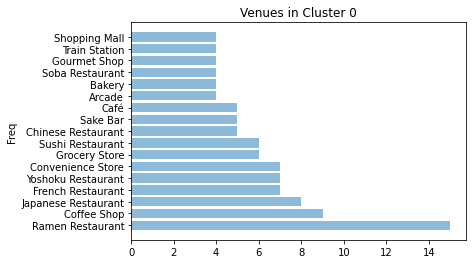

In [88]:
lis = (clus0.iloc[:,5:8])
lis['ID'] = np.arange(0,len(lis),1)
output_df = lis.melt(id_vars=["ID"])
#output_df
value0 = output_df.iloc[:,2].value_counts()
value0 = pd.DataFrame(value0)
value0 = value0.loc[value0["value"] > 3]
value0.reset_index(level=0, inplace=True)
plt.barh(value0["index"], value0["value"], align='center', alpha=0.5)
plt.ylabel('Freq')
plt.title('Venues in Cluster 0')

plt.show()

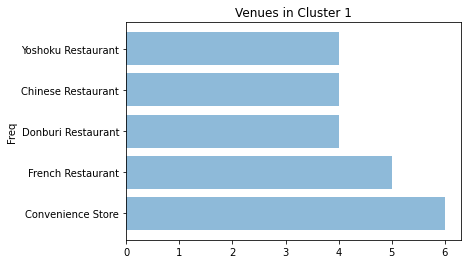

In [89]:
lis = (clus1.iloc[:,5:8])
lis['ID'] = np.arange(0,len(lis),1)
output_df = lis.melt(id_vars=["ID"])
#output_df
value0 = output_df.iloc[:,2].value_counts()
value0 = pd.DataFrame(value0)
value0 = value0.loc[value0["value"] > 3]
value0.reset_index(level=0, inplace=True)
plt.barh(value0["index"], value0["value"], align='center', alpha=0.5)
plt.ylabel('Freq')
plt.title('Venues in Cluster 1')

plt.show()

C:\Users\kimgl\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



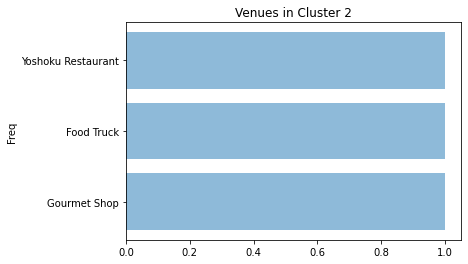

In [91]:
lis = (clus2.iloc[:,5:8])
lis['ID'] = np.arange(0,len(lis),1)
output_df = lis.melt(id_vars=["ID"])
#output_df
value0 = output_df.iloc[:,2].value_counts()
value0 = pd.DataFrame(value0)
value0 = value0.loc[value0["value"] > 0]
value0.reset_index(level=0, inplace=True)
plt.barh(value0["index"], value0["value"], align='center', alpha=0.5)
plt.ylabel('Freq')
plt.title('Venues in Cluster 2')

plt.show()

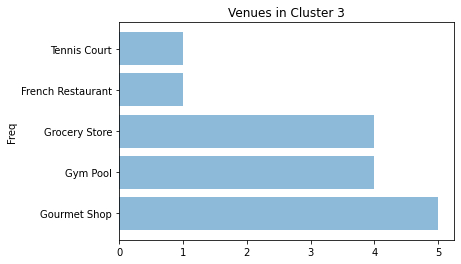

In [92]:
lis = (clus3.iloc[:,5:8])
lis['ID'] = np.arange(0,len(lis),1)
output_df = lis.melt(id_vars=["ID"])
#output_df
value0 = output_df.iloc[:,2].value_counts()
value0 = pd.DataFrame(value0)
value0 = value0.loc[value0["value"] > 0]
value0.reset_index(level=0, inplace=True)
plt.barh(value0["index"], value0["value"], align='center', alpha=0.5)
plt.ylabel('Freq')
plt.title('Venues in Cluster 3')

plt.show()

So it looks like cluster 0 has the most interesting venues.  Of the districts in cluster 0, I want to find the ones with light rail stations and hotels. So I will take a data frame of cluster 0 and make the dataframe long by using the districts as an ID and then only select the districts that have both light rails and hotels.

In [76]:
Narrowing = clus0.iloc[:,[1,6, 7, 8, 9, 10, 11, 12, 13 ,14, 15]]
Narrowing = Narrowing.melt(id_vars=["District"])
Narrowing


IndexError: positional indexers are out-of-bounds

In [46]:
HotelStation = Narrowing.loc[Narrowing['value'].isin(['Hotel','Light Rail Station'])]
ids = HotelStation["District"]
HotelStation[ids.isin(ids[ids.duplicated()])]

District               variable               value
5     Ariake  1st Most Common Venue               Hotel
341   Ariake  5th Most Common Venue  Light Rail Station

It seems like only Ariake has both a Light Rail Station and a hotel, so let's find out where Ariake is relative to everything else.

In [57]:
tokyo_merged.loc[tokyo_merged['District'].isin(['Ariake'])]

wa District  Ward   Longitude   Latitude Station 1st Most Common Venue  \
7  40   Ariake  Koto  139.793256  35.634556     NaN                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
7     Convenience Store            Restaurant                  Café   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
7    Light Rail Station     Electronics Store            Food Truck   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  Clusters  
7          Fishing Spot  Fast Food Restaurant         Farmers Market         0

In [60]:
# create map
from folium import BeautifyIcon
map_clusters = folium.Map(location=[35.6828387, 139.7594549], zoom_start=10)

map_clusters.choropleth(
    geo_data=tokyo_geo,
    data=df,
    columns=['Ward', 'Density'],
    key_on='feature.properties.ward_en',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tokyo Ward Density'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['District'], tokyo_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

icon_star = BeautifyIcon(
    icon='star',
    inner_icon_style='color:black;font-size:30px;',
    background_color='transparent',
    border_color='transparent',
)

folium.Marker([35.634556, 139.793256], tooltip='star', icon=icon_star).add_to(map_clusters)
    
map_clusters


ImportError: cannot import name 'BeautifyIcon' from 'folium' (C:\Users\kimgl\anaconda3\lib\site-packages\folium\__init__.py)

I also want to look at places that just have a light rail station or just a hotel.  For the places that only have a light rail station, I could look into an Airbnb in the area.  For places that only have a hotel, there may be a light rail station nearby.

In [55]:
Station = Narrowing.loc[Narrowing['value'].isin(['Metro Station','Light Rail Station', 'Train Station'])]
Station

District               variable               value
11   Etchujima  1st Most Common Venue       Train Station
18   Hatanodai  1st Most Common Venue       Train Station
54         Oji  1st Most Common Venue       Train Station
66   Shinagawa  1st Most Common Venue       Train Station
125    Machiya  2nd Most Common Venue       Train Station
147  Shibamata  2nd Most Common Venue       Train Station
155     Tabata  2nd Most Common Venue       Train Station
341     Ariake  5th Most Common Venue  Light Rail Station

In [56]:
Station = Narrowing.loc[Narrowing['value'].isin(['Hotel'])]
Station

District                variable  value
5        Ariake   1st Most Common Venue  Hotel
224       Omori   3rd Most Common Venue  Hotel
235   Shinbashi   3rd Most Common Venue  Hotel
309    Otemachi   4th Most Common Venue  Hotel
462  Marunouchi   6th Most Common Venue  Hotel
523  Hatchobori   7th Most Common Venue  Hotel
675        Aoto   9th Most Common Venue  Hotel
678     Asagaya   9th Most Common Venue  Hotel
794      Koenji  10th Most Common Venue  Hotel
808     Ogikubo  10th Most Common Venue  Hotel

In [60]:
tokDistricts = pd.read_csv('districtsLatLong2.csv')
map_tokyo = folium.Map(location=[35.6828387, 139.7594549], zoom_start=11, tiles='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png', attr='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png')

# add markers to map
for lat, lng, borough, neighborhood, color in zip(tokDistricts['Latitude'], tokDistricts['Longitude'], tokDistricts['Ward'], tokDistricts['District'], tokDistricts['Color']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
    
map_tokyo